# 摘要

# 理论模型

菜籽油俗称菜油（以下称菜油），是以油菜籽（以下简称菜籽）压榨所得的透明或半透明状液体，色泽棕黄或棕褐色。菜籽含油率高，可达 35％-45％，其主要用途是榨油。菜油在世界四大植物油中居第三位，是我国生产的最大的植物油，也是我国消费的第三大植物油。

![菜籽油](.\images\菜籽油.PNG)


## 用途

**健康的植物油**

菜油是最有利于人体健康的食用油之一。双低菜油的饱和脂肪酸含量只有 7%，在所有油脂品种中含量最低，饱和脂肪酸含量高易使胆固醇升高，患心脏病的危险增大。双低菜油单不饱和脂肪酸含量在 61% 左右，仅次于橄榄油，而不饱和脂肪酸具有降低低密度脂肪蛋白胆固醇、减少心血管疾病的作用。研究证明，食用双低菜油人群的胆固醇含量较常规饮食人群低 15%-20%。加拿大每年消费菜油达 100 万吨，而消费动物油只 2.5 万吨。美国人以前主要食用大豆油，很少食用菜油，近年来，双低菜油在美国的消费量每年以 10%-20% 的速度增加。

**良好的生物柴油原料**

菜油凝固点在 -8℃～-10℃，远低于其他油脂，是良好的生物柴油原料。近几年，菜油转化为生物柴油的比例逐年增加，其中，欧盟菜油消费的 60% 以上用于生物柴油。

我国菜油主要是食用，占我国消费量的 90％ 以上。我国菜油的加工、贸易、储藏和消费以四级油为主，四级菜油贸易量占菜油现货贸易量的 80％ 以上，国家储备和地方储备的菜油也都是四级油。四级菜油既可以直接消费，也可以精炼成一级菜油（原国标色拉油）消费。四级菜油的价格是现货市场菜油的基准价格。



# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

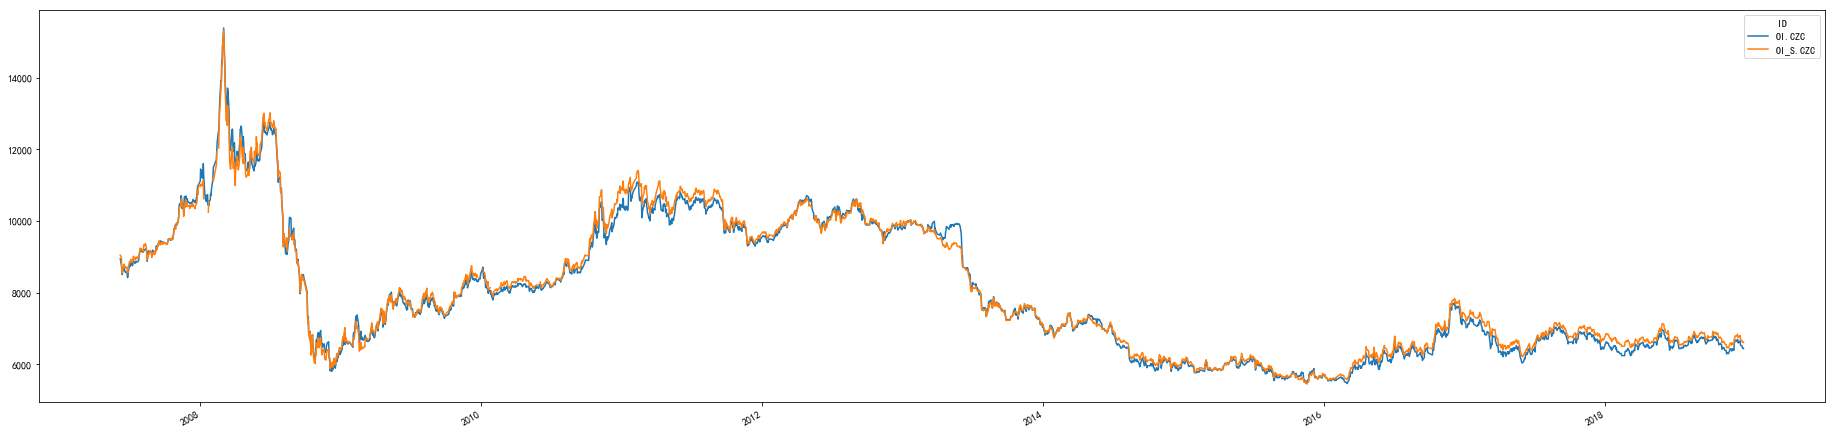

In [2]:
# 参数设置和数据准备
Exchange = "CZCE"
MID, SID = "OI.CZC", "OI_S.CZC"# 主力合约, 次主力合约
StartDT = dt.datetime(2007, 6, 8)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=[PriceFactor], ids=FutureIDMap.columns.tolist(), dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
CCPrice.plot(kind="line", ax=Axes);

# 附录
​
## 期货

![菜籽油期货合约](.\images\菜籽油期货合约.PNG)

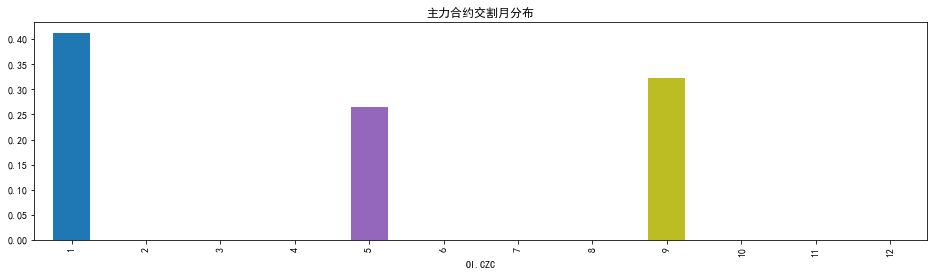

In [3]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

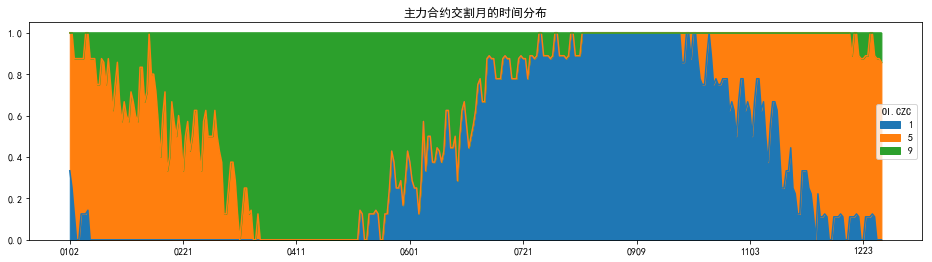

In [4]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);